In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os
import tqdm
import glob
import tensorflow

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
#from skimage.color import rgb2grey # The rgb2grey function was likely renamed in a later version of scikit-image
from skimage.color import rgb2gray # Use rgb2gray instead of rgb2grey
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50 
from tensorflow.keras.preprocessing.image import load_img, img_to_array



In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [5]:
train_dataset  = train_datagen.flow_from_directory(directory = r'D:\CODING\Alzheimer_s Dataset\train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [7]:
valid_dataset = valid_datagen.flow_from_directory(directory = r'D:\CODING\Alzheimer_s Dataset\train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


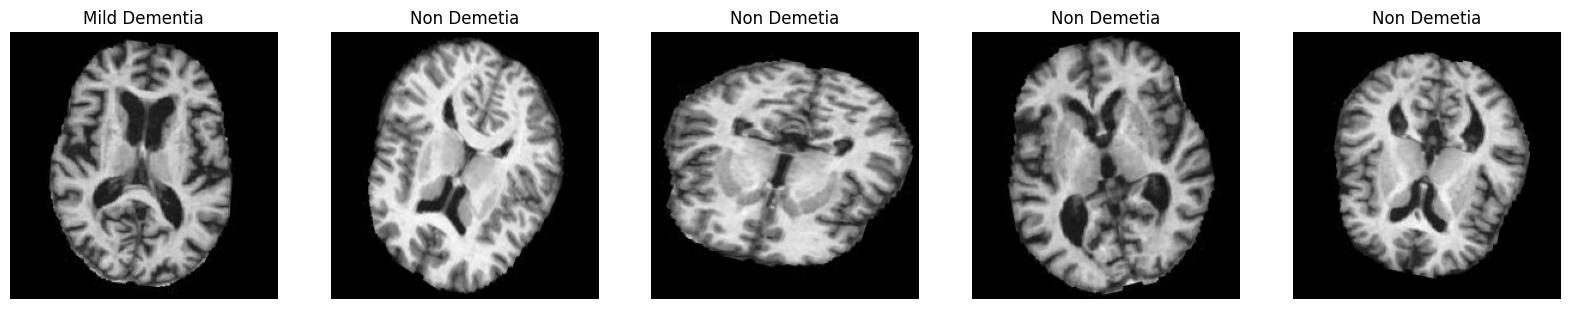

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [9]:
import tensorflow as tf # Make sure to import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model

# Input shape for the model
input_shape = (224, 224, 3)

# Load the ResNet50 model without the top classification layers
base_model = ResNet50(input_shape=input_shape, include_top=False, weights="imagenet")

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model by adding layers on top of the base model
inputs = tf.keras.Input(shape=input_shape)
x = base_model(inputs, training=False)  # Set training=False to freeze base_model during training
x = Dropout(0.5)(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(2048, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Print the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100352)         │       401,408 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │   205,522,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,626,628 (883.59 MB)

 Trainable params: 207,832,068 (792.82 MB)

 Non-trainable params: 23,794,560 (90.77 MB)

In [12]:
OPT = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [17]:
filepath = './best_weights.keras' # Change the file extension to .keras

earlystopping = EarlyStopping(monitor = 'val_auc',
                              mode = 'max' ,
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, # Pass the updated filepath
                                monitor = 'val_auc',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ... (Previous code remains the same) ...
# Modify the model architecture
# Use GlobalAveragePooling2D instead of Flatten
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)  # Replace Flatten() with GlobalAveragePooling2D()
x = Dropout(0.5)(x)
# ... (Rest of the model architecture remains the same) ...

# ... (Compile and fit as before) ...

model_history = model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs=5,
                        callbacks=callback_list,
                        verbose=1)

Epoch 1/5


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - auc: 0.7035 - loss: 1.6793
Epoch 1: val_auc improved from -inf to 0.49545, saving model to ./best_weights.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 433s 12s/step - auc: 0.7050 - loss: 1.6734 - val_auc: 0.4955 - val_loss: 3.2194
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - auc: 0.7770 - loss: 1.2971 
Epoch 2: val_auc improved from 0.49545 to 0.78199, saving model to ./best_weights.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 602s 18s/step - auc: 0.7772 - loss: 1.2962 - val_auc: 0.7820 - val_loss: 1.1717
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - auc: 0.7984 - loss: 1.1581
Epoch 3: val_auc did not improve from 0.78199
33/33 ━━━━━━━━━━━━━━━━━━━━ 346s 10s/step - auc: 0.7984 - loss: 1.1577 - val_auc: 0.7033 - val_loss: 1.1917
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - auc: 0.7999 - loss: 1.1066
Epoch 4: val_auc did not improve from 0.78199
33/33 ━━━━━━━━━━━━━━━━━━━━ 345s 10s/step - auc: 0.7999 - loss: 1.1063 - val_auc: 0.6864 - val_loss: 1.2774
Epoch 5

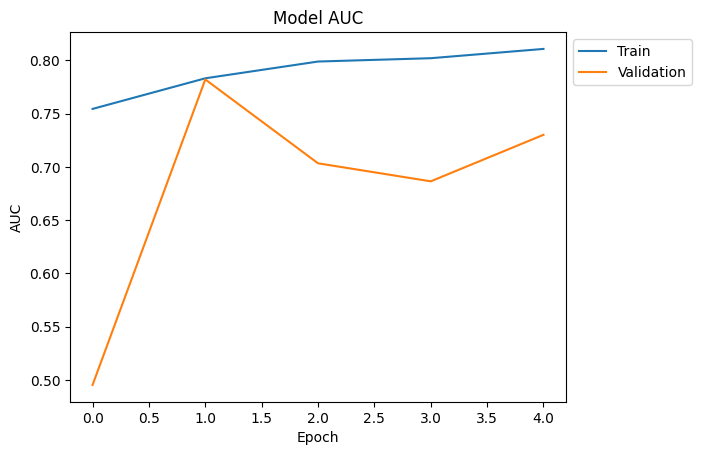

In [21]:
plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

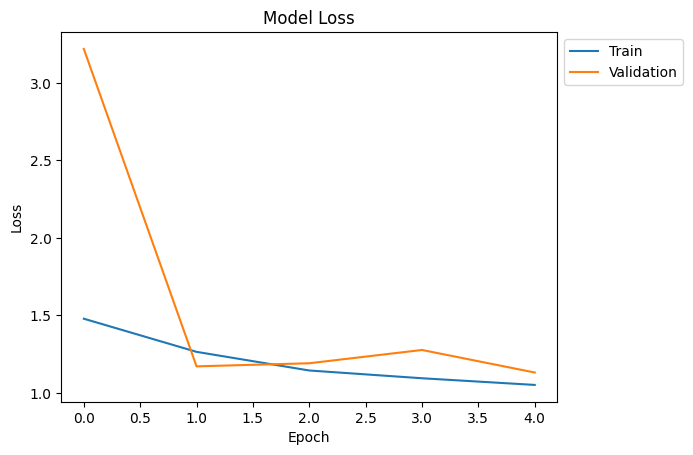

In [23]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [25]:
test_dataset  = test_datagen.flow_from_directory(directory = r'D:\CODING\Alzheimer_s Dataset\test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 1279 images belonging to 4 classes.


In [27]:
model.evaluate(test_dataset)

10/10 ━━━━━━━━━━━━━━━━━━━━ 72s 7s/step - auc: 0.8049 - loss: 1.0007


[0.9729667901992798, 0.8154188394546509]

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib.pyplot import imshow

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img(r"D:\CODING\Alzheimer_s Dataset\test\NonDemented\26 (84).jpg", target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

# Replace predict_classes with predict and argmax for class prediction
predictions = model.predict(img) # Get the model's predictions
answer = np.argmax(predictions)  # Get the index of the class with the highest probability

probability = round(np.max(predictions)*100,2)

print(probability, '% chances are there that the image is',idc[answer])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
47.32 % chances are there that the image is VeryMildDemented


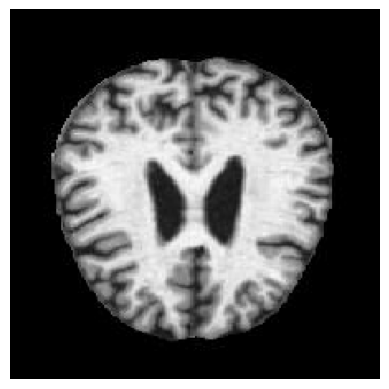

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib.pyplot import imshow

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img(r"D:\CODING\Alzheimer_s Dataset\test\VeryMildDemented\32.jpg", target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

# Replace predict_classes with predict and argmax for class prediction
predictions = model.predict(img) # Get the model's predictions
answer = np.argmax(predictions)  # Get the index of the class with the highest probability

probability = round(np.max(predictions)*100,2)

print(probability, '% chances are there that the image is',idc[answer])

In [ ]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')

In [35]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()

In [37]:
test_generator = test_datagen.flow_from_directory(
    r'D:\CODING\Alzheimer_s Dataset\test',  # Replace with the actual path
    target_size=(224, 224),  # Change this to 224x224 to match DenseNet121's input size
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1279 images belonging to 4 classes.


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 750ms/step


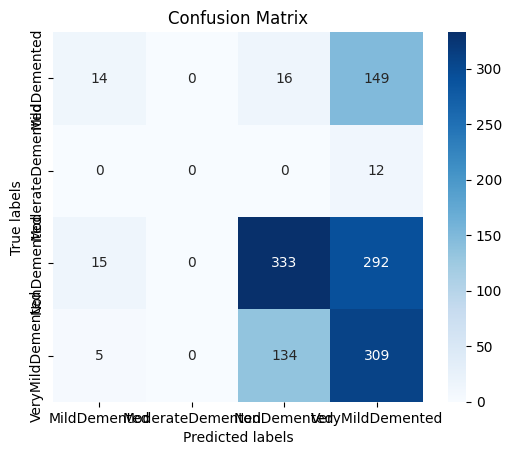

Precision per class: {'MildDemented': 0.4117647058823529, 'ModerateDemented': 0.0, 'NonDemented': 0.6894409937888198, 'VeryMildDemented': 0.40551181102362205}

Classification Report:
                   precision    recall  f1-score   support

    MildDemented       0.41      0.08      0.13       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.69      0.52      0.59       640
VeryMildDemented       0.41      0.69      0.51       448

        accuracy                           0.51      1279
       macro avg       0.38      0.32      0.31      1279
    weighted avg       0.54      0.51      0.49      1279



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, precision_score

# Function to plot confusion matrix and precision
def plot_confusion_matrix(true_lab, predicted_lab, classes, path):
    matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
    
    # Plotting the confusion matrix using seaborn heatmap
    ax = plt.subplot()
    sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
    
    # Labels, titles, and other visual details
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    
    # Save plot to file if needed
    plt.savefig(path)
    plt.show()
    
    # Calculate precision for each class
    precision = precision_score(true_lab, predicted_lab, average=None)
    print("Precision per class:", dict(zip(classes, precision)))
    
    # Display classification report for detailed metrics
    print("\nClassification Report:\n", classification_report(true_lab, predicted_lab, target_names=classes))

# Confusion Matrix for ResNet50
p = model.predict(test_generator)
predicted_lab = p.argmax(axis=-1)
true_lab = test_generator.classes

# Use the function and provide the file path
plot_confusion_matrix(true_lab, predicted_lab, list(test_generator.class_indices.keys()), 'confusion_matrix.png')
